(PosixPath('../../datasets/UrbanSound8K/audio/fold5/100263-2-0-117.wav'), 'humans/others')
44100


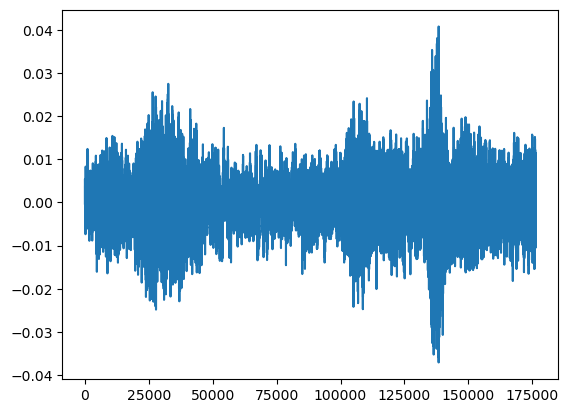

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
import os.path
import yaml
import logging
import json
import argparse
from fusanet_utils.experiments.initializer import initialize_model, create_dataset, create_dataloaders
from fusanet_utils.experiments.trainer import train_model
from fusanet_utils.experiments.evaluator import evaluate_model
from IPython.display import Audio

import torchaudio
import librosa
from fusanet_utils.datasets.external import UrbanSound8K

us = UrbanSound8K('../../')
print(us[0])
waveform, rate = torchaudio.load(us[0][0])
print(rate)
fig, ax = plt.subplots()
ax.plot(waveform[0])
Audio(data=waveform, rate=rate)

{'features': {'sampling_rate': 32000,
  'overwrite': False,
  'number_of_channels': 1,
  'combine_channels': 'mean',
  'collate_resize': 'adaptive-5s',
  'waveform_normalization': {'scope': None, 'type': None}},
 'train': {'random_seed': 1234,
  'train_percent': 0.8,
  'nepochs': 100,
  'balanced': False,
  'learning_rate': 0.001,
  'batch_size': 64,
  'model': 'PANN-tag',
  'dataset': ['US'],
  'stopping_criteria': 'valid_loss',
  'patience': 15,
  'augmentation': None,
  'pretrained': True,
  'cuda': False},
 'evaluate': {'dataset': ['US'], 'cuda': True}}

['US']


100%|███| 8441/8441 [00:00<00:00, 13136.44it/s]


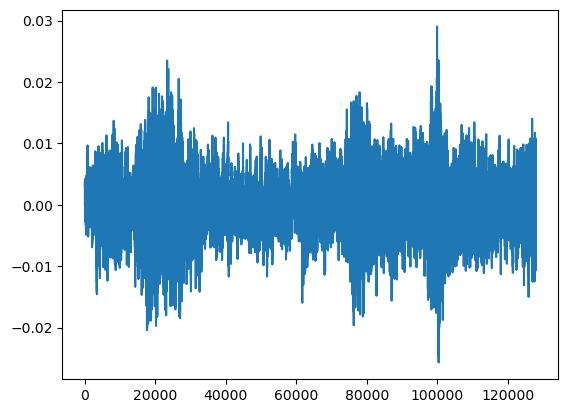

In [5]:
params = yaml.safe_load(open("params.yaml"))
params['train']['cuda'] = False
params['features']['waveform_normalization']['scope'] = None
params['features']['waveform_normalization']['type'] = None
params['train']['augmentation'] = None
params['features']['collate_resize'] = 'adaptive-5s'
display(params)

dataset = create_dataset('../../', params, stage='train')
waveform_dataset = dataset[0]['waveform'][0, :]

fig, ax = plt.subplots()
ax.plot(waveform_dataset)

Audio(data=waveform_dataset, rate=params['features']['sampling_rate'])

[128000, 128000, 128000, 128000, 128000] 128000
torch.Size([5, 1, 160000])


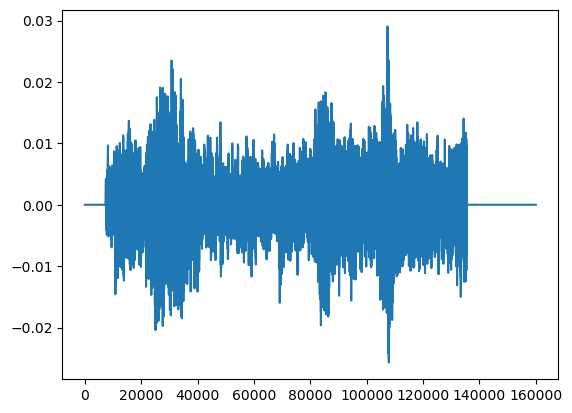

In [7]:
from torch.utils.data import DataLoader
from fusanet_utils.transforms import Collate_and_transform

collate = Collate_and_transform(params['features'])

batch_list = [dataset[k] for k in range(5)]
batch_size = [x['waveform'].shape[-1] for x in batch_list]
print(batch_size, min(batch_size))

batch = collate(batch_list)
print(batch['waveform'].shape)

fig, ax = plt.subplots()
ax.plot(batch['waveform'][0][0])
Audio(data=batch['waveform'][0][0], rate=params['features']['sampling_rate'])

In [8]:
import torch
import sklearn
import time
from torch.profiler import profile, record_function, ProfilerActivity

eps = torch.finfo(torch.float).eps

def accuracy(y, label):
    if label.ndim == 3: # SED
        return torch.sum((y > 0.5) == label)/(label.shape[1]*label.shape[2])
    else:
        return torch.sum(y.argmax(1) == label)

def f1_score(y, label):
    if label.ndim == 3: # SED
        frames_in_1_sec = 100
        y = torch.where(y > 0.5, 1., 0.)
        f1_score = np.round(f1_overall_1sec(y, label, frames_in_1_sec), 3)
        return f1_score
    else:
        return sklearn.metrics.f1_score(label.cpu().numpy(), y.cpu().argmax(dim=1).numpy(), average='macro')

    
train_loader, valid_loader = create_dataloaders(dataset, params)
initialize_model('asd.pt', params['train'], len(dataset.categories))
n_train, n_valid = len(train_loader.dataset), len(valid_loader.dataset)
model = torch.load('asd.pt')
optimizer = torch.optim.Adam(model.parameters(), lr=params['train']['learning_rate'])
clip = 10.0
criterion = torch.nn.CrossEntropyLoss()

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:

    global_loss = 0.0
    global_accuracy = 0.0
    global_f1_score = 0.0
    model.train()

    for batch in train_loader:
        optimizer.zero_grad()
        y = model.forward(batch)
        loss = criterion(y, batch['label'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        global_loss += loss.detach()
        global_accuracy += accuracy(y, batch['label']).detach()
        global_f1_score += f1_score(y, batch['label'])
        break

In [9]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::convolution         0.01%       1.214ms        76.02%       13.669s     594.294ms            23  
                                     aten::_convolution         0.01%       1.569ms        76.01%       13.668s     594.241ms            23  
                               aten::mkldnn_convolution        75.97%       13.659s        75.97%       13.660s     593.928ms            23  
                                           aten::conv2d         0.00%     241.000us        53.82%        9.678s     691.288ms            14  
      

In [ ]:
import torch
import sklearn
import time
from torch.profiler import profile, record_function, ProfilerActivity

eps = torch.finfo(torch.float).eps

def accuracy(y, label):
    if label.ndim == 3: # SED
        return torch.sum((y > 0.5) == label)/(label.shape[1]*label.shape[2])
    else:
        return torch.sum(y.argmax(1) == label)

def f1_score(y, label):
    if label.ndim == 3: # SED
        frames_in_1_sec = 100
        y = torch.where(y > 0.5, 1., 0.)
        f1_score = np.round(f1_overall_1sec(y, label, frames_in_1_sec), 3)
        return f1_score
    else:
        return sklearn.metrics.f1_score(label.cpu().numpy(), y.cpu().argmax(dim=1).numpy(), average='macro')

   
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

train_loader, valid_loader = create_dataloaders(dataset, params)
initialize_model('asd.pt', params['train'], len(dataset.categories))
n_train, n_valid = len(train_loader.dataset), len(valid_loader.dataset)
model = torch.load('asd.pt')
optimizer = torch.optim.Adam(model.parameters(), lr=params['train']['learning_rate'])
clip = 10.0
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(params["train"]["nepochs"]):
#for epoch in range(1):
    global_loss = 0.0
    global_accuracy = 0.0
    global_f1_score = 0.0
    model.train()
    
    start_time = time.time()
    for batch in train_loader:
        optimizer.zero_grad()
        y = model.forward(batch)
        loss = criterion(y, batch['label'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        global_loss += loss.detach()
        global_accuracy += accuracy(y, batch['label']).detach()
        global_f1_score += f1_score(y, batch['label'])
    global_loss = global_loss.item()
    logger.info(f"{epoch}, train/loss {global_loss/n_train:0.4f}")
    logger.info(f"{epoch}, train/accuracy {global_accuracy/n_train:0.4f}")
    logger.info(f"{epoch}, train/f1_score_macro {global_f1_score/len(valid_loader):0.4f}")
    logger.info(f"train time: {time.time() - start_time:0.4f} [s]")

    global_loss = 0.0
    global_accuracy = 0.0
    global_f1_score = 0.0
    global_error_rate = 0.0
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for batch in valid_loader:
            y = model.forward(batch)
            loss = criterion(y, batch['label'])
            global_loss += loss
            global_accuracy += accuracy(y, batch['label']).detach()
            global_f1_score += f1_score(y, batch['label'])
    global_loss = global_loss.item()
    logger.info(f"{epoch}, valid/loss {global_loss/n_valid:0.4f}")
    logger.info(f"{epoch}, valid/accuracy {global_accuracy/n_valid:0.4f}")
    logger.info(f"{epoch}, valid/f1_score_macro {global_f1_score/len(valid_loader):0.4f}")
    logger.info(f"valid time: {time.time() - start_time:0.4f} [s]")
